<a href="https://colab.research.google.com/github/rakibhossainporosh/Counfusion-Matrix/blob/main/Counfusion_Matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Generate a dataset with 1000 samples, 2 classes (binary), with slight imbalance
X, y = make_classification(
    n_samples=1000,
    n_classes=2,
    weights=[0.6, 0.4],  # 60% class 0, 40% class 1
    n_features=2,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=42
)

# Initial split: 80% for training+validation, 20% for test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# From the 80%, split into 60% training and 20% validation (i.e., 75% train / 25% val of X_temp)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Check sizes
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")



Training set: (600, 2), Validation set: (200, 2), Test set: (200, 2)


In [2]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train Decision Tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on validation set
y_pred_val = clf.predict(X_val)
y_prob_val = clf.predict_proba(X_val)[:, 1]  # probabilities for ROC curve

# Show predictions shape for confirmation
print("Predictions shape:", y_pred_val.shape)

Predictions shape: (200,)


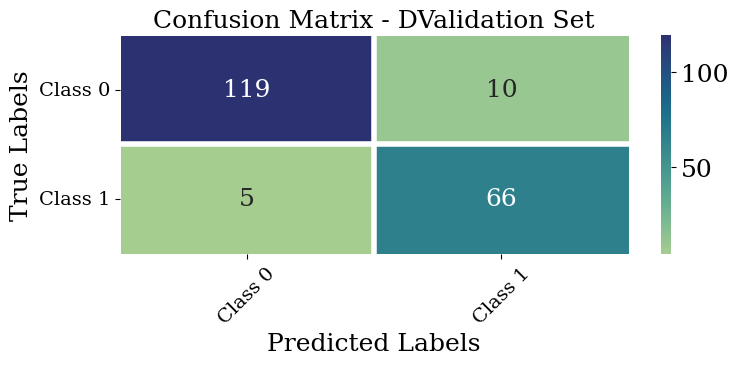

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred_val)

# Title for the confusion matrix
title = "Confusion Matrix - DValidation Set"

# Set font properties globally
plt.rcParams.update({
    'font.size': 18,
    'font.family': 'serif',
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18
})

# Create figure
fig, ax = plt.subplots(figsize=(8, 4))

# Define color map
cmap = sns.color_palette("crest", as_cmap=True)

# Plot heatmap with borders
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=True,
            ax=ax, annot_kws={"fontsize": 18}, linewidths=0.5, linecolor='white')

# Axis labels and ticks
ax.set_title(title)
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_xticklabels(["Class 0", "Class 1"], rotation=45, fontsize=14)
ax.set_yticklabels(["Class 0", "Class 1"], rotation=0, fontsize=14)

# Gridlines inside the heatmap
ax.hlines([1], *ax.get_xlim(), colors='white', linewidth=4)
ax.vlines([1], *ax.get_ylim(), colors='white', linewidth=4)

# Show plot
plt.tight_layout()
plt.show()



In [4]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, balanced_accuracy_score,
    matthews_corrcoef
)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred_val)
TN, FP, FN, TP = cm.ravel()

# Core metrics
accuracy = accuracy_score(y_val, y_pred_val)
precision = precision_score(y_val, y_pred_val)
recall = recall_score(y_val, y_pred_val)  # TPR
f1 = f1_score(y_val, y_pred_val)
roc_auc = roc_auc_score(y_val, y_prob_val)

# Additional metrics
specificity = TN / (TN + FP)                          # TNR
fpr = FP / (FP + TN)                                  # FPR
fnr = FN / (FN + TP)                                  # FNR
balanced_acc = balanced_accuracy_score(y_val, y_pred_val)
mcc = matthews_corrcoef(y_val, y_pred_val)

# Print all metrics
print(f"\nAccuracy:              {accuracy:.4f}")
print(f"Precision (PPV):        {precision:.4f}")
print(f"Recall (Sensitivity):   {recall:.4f}")
print(f"F1 Score:               {f1:.4f}")
print(f"ROC AUC:                {roc_auc:.4f}")
print(f"Specificity (TNR):      {specificity:.4f}")
print(f"False Positive Rate:    {fpr:.4f}")
print(f"False Negative Rate:    {fnr:.4f}")
print(f"Balanced Accuracy:      {balanced_acc:.4f}")
print(f"Matthews Corr Coef:     {mcc:.4f}")


Accuracy:              0.9250
Precision (PPV):        0.8684
Recall (Sensitivity):   0.9296
F1 Score:               0.8980
ROC AUC:                0.9260
Specificity (TNR):      0.9225
False Positive Rate:    0.0775
False Negative Rate:    0.0704
Balanced Accuracy:      0.9260
Matthews Corr Coef:     0.8400


In [5]:
from sklearn.metrics import classification_report, roc_curve
import matplotlib.pyplot as plt

# Classification report
report = classification_report(y_val, y_pred_val, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.96      0.92      0.94       129
     Class 1       0.87      0.93      0.90        71

    accuracy                           0.93       200
   macro avg       0.91      0.93      0.92       200
weighted avg       0.93      0.93      0.93       200



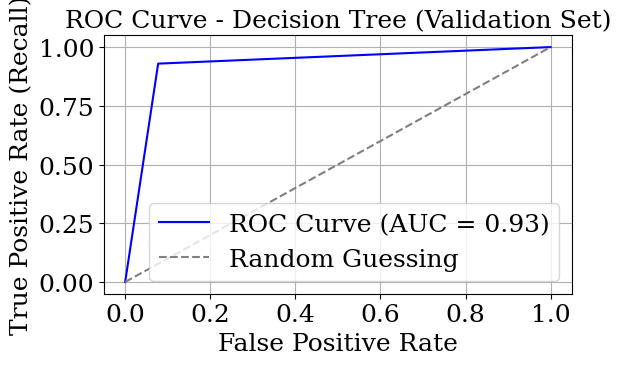

In [6]:
fpr, tpr, thresholds = roc_curve(y_val, y_prob_val)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - Decision Tree (Validation Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score

# Define 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predict probabilities using cross-validation
y_cv_prob = cross_val_predict(clf, X_train, y_train, cv=cv, method='predict_proba')[:, 1]

# ROC AUC from cross-validated predictions
cv_auc = roc_auc_score(y_train, y_cv_prob)

print(f"Cross-Validation ROC AUC (5-fold): {cv_auc:.4f}")


Cross-Validation ROC AUC (5-fold): 0.9216
